In [1]:
from IPython.display import HTML

In [2]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);

# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Data Storytelling Project: SAT New York

**Objectives:**
* Analyse SAT scores + demographics and any other relevant information available
* Check fairness of the [SAT](https://www.insidehighered.com/news/2010/06/21/sat)

**Summary:**
* SAT correlation:
    * 'SAT Math Avg. Score' and 'SAT Writing Avg. Score' strongly correlates with 'SAT_score'
    * 'ell_percent' (% of students in each school who are learning English) correlates negatively with 'SAT_score'
    * 'total_enrollment' correlates positively with 'SAT_score'
    * It's possibile to identify some racial inequality in the data, with 'hispanic_per' and 'black_per' correlating negatively with 'SAT_score'
    * 'female_per' correlates positively with 'SAT_score'
    * 'male_per' correlates negatively with 'SAT_score'


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium.plugins import MarkerCluster, HeatMap

# Allow modules and files to be loaded with relative paths
import os
import glob
path = "../data/*.csv"

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Understanding the data

### Read data into dataframe, put each dataframe into a dictionary

In [4]:
def load_files(path):
    """
    Takes csv files, convert them to data dictionary.
    Args:
        Data path
    Returns:
        data dictionary.
    """
    data = {}
    for file_ in glob.glob(path):
        file_name = os.path.splitext(os.path.basename(file_))[0]
        print file_
        d = pd.read_csv("{}".format(file_))
        data[file_.replace(file_, file_name)] = d
    return data
    


### Check dictionary

In [6]:
#path = "../data/*.csv"
data = load_files(path)
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head())

../data/AP_results.csv
../data/Class_size.csv
../data/Demographics.csv
../data/Graduation_outcomes.csv
../data/hsdirectory.csv
../data/Math_test_results.csv
../data/SAT_Results.csv

Math_test_results

      DBN Grade  Year      Category  Number Tested Mean Scale Score Level 1 #  \
0  01M015     3  2006  All Students             39              667         2   
1  01M015     3  2007  All Students             31              672         2   
2  01M015     3  2008  All Students             37              668         0   
3  01M015     3  2009  All Students             33              668         0   
4  01M015     3  2010  All Students             26              677         6   

  Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 # Level 4 %  \
0      5.1%        11     28.2%        20     51.3%         6     15.4%   
1      6.5%         3      9.7%        22       71%         4     12.9%   
2        0%         6     16.2%        29     78.4%         2      5.4%   
3        0% 

**Patterns/preliminary analysis:**

* District Borough Number (DBN): Math_test_results, SAT_results, Demographics, AP_results, Graduation_outcomes, hsdirectory
* School name: SAT_results, AP_results, Graduation_outcomes, Class_size, hsdirectory
* Location1 field in hsdirectory can be used for maps

### Data unification  

This makes working with all the data an easier process.
DBN is a common column, it just doesnt appear in Class_size - unless School code is DBN.

I will check how DBN looks and compare against Class_size to try to recognize a pattern

In [7]:
data["AP_results"]["DBN"].head()

0    01M448
1    01M450
2    01M515
3    01M539
4    02M296
Name: DBN, dtype: object

In [8]:
data["Class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


It looks like DBN is combination of CSD, BOROUGH, and SCHOOL CODE.

from [string format](https://docs.python.org/2/library/stdtypes.html#str.format) [documentation](https://docs.python.org/3/library/string.html#format-string-syntax):

{:02d}

02d formats an integer (d) to a field of minimum width 2 (2), with zero-padding on the left (leading 0)


In [9]:
data["Class_size"]["DBN"] = data["Class_size"].apply(lambda x: "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)
data["hsdirectory"].rename(columns={'dbn': 'DBN'}, inplace=True)

In [10]:
data["Class_size"].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015


I will now combine the survey data into one:

In [11]:
def load_txt(path_to_file, filename):
    """
    Takes a txt, convert them to a dataframe.
    Args:
        Data path and file name
    Returns:
        data frame.
    """
    fp = os.path.join(path_to_file, filename)
    d = pd.read_csv(fp, delimiter = "\t")
    return d

In [12]:
path_to_file = "../data/survey/"
s1 = "masterfile11_gened_final.txt"
s2 = "masterfile11_d75_final.txt"
survey1 = load_txt(path_to_file, s1)
survey2 = load_txt(path_to_file, s1)

In [13]:
survey1.head(3)

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_N_q14e_3,s_N_q14e_4,s_N_q14f_1,s_N_q14f_2,s_N_q14f_3,s_N_q14f_4,s_N_q14g_1,s_N_q14g_2,s_N_q14g_3,s_N_q14g_4
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
survey2.head(3)

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_N_q14e_3,s_N_q14e_4,s_N_q14f_1,s_N_q14f_2,s_N_q14f_3,s_N_q14f_4,s_N_q14g_1,s_N_q14g_2,s_N_q14g_3,s_N_q14g_4
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add 'False' to the d75 field in survey one (which corresponds to all schools) and 'True' to survey2 (which corresponds to school district 75)

In [15]:
survey1["d75"] = False
survey2["d75"] = True

Concatenate survey1 and survey2 vertically

In [16]:
survey = pd.concat([survey1, survey2], axis=0)

In [17]:
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_N_q14e_3,s_N_q14e_4,s_N_q14f_1,s_N_q14f_2,s_N_q14f_3,s_N_q14f_4,s_N_q14g_1,s_N_q14g_2,s_N_q14g_3,s_N_q14g_4
0,01M015,M015,P.S. 015 Roberto Clemente,False,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,False,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,False,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,False,Yes,0.0,Elementary / Middle School,89.0,73,50,...,20.0,16.0,23.0,54.0,33.0,29.0,31.0,46.0,16.0,8.0
4,01M063,M063,P.S. 063 William McKinley,False,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check data dictionary file (Survey Data Dictionary.xls) to define which columns are relevant

In [18]:
survey["DBN"] = survey["dbn"]
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]

In [19]:
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_N_q14e_4,s_N_q14f_1,s_N_q14f_2,s_N_q14f_3,s_N_q14f_4,s_N_q14g_1,s_N_q14g_2,s_N_q14g_3,s_N_q14g_4,DBN
0,01M015,M015,P.S. 015 Roberto Clemente,False,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01M015
1,01M019,M019,P.S. 019 Asher Levy,False,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01M019
2,01M020,M020,P.S. 020 Anna Silver,False,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01M020
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,False,Yes,0.0,Elementary / Middle School,89.0,73,50,...,16.0,23.0,54.0,33.0,29.0,31.0,46.0,16.0,8.0,01M034
4,01M063,M063,P.S. 063 William McKinley,False,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01M063


In [20]:
# getting only the relevant fields
# note that '.loc' was used because it works on lables. If I was working on the positions in the index, I would use iloc
survey = survey.loc[:,survey_fields]

In [21]:
survey.head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


I need to add the survey to the data dictionary

In [22]:
data["survey"] = survey
#survey.shape

In [23]:
data['survey'].head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


### Checking the datasets

In [24]:
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head(3))


Math_test_results

      DBN Grade  Year      Category  Number Tested Mean Scale Score Level 1 #  \
0  01M015     3  2006  All Students             39              667         2   
1  01M015     3  2007  All Students             31              672         2   
2  01M015     3  2008  All Students             37              668         0   

  Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 # Level 4 %  \
0      5.1%        11     28.2%        20     51.3%         6     15.4%   
1      6.5%         3      9.7%        22       71%         4     12.9%   
2        0%         6     16.2%        29     78.4%         2      5.4%   

  Level 3+4 # Level 3+4 %  
0          26       66.7%  
1          26       83.9%  
2          31       83.8%  

SAT_Results

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNIT

Math_test_results, Demographics, Graduation_outcomes, Class_size have several rows for each high school (DBN and School name fields).

I will need to find a way to condensate the datasets above to "one row per high school". If that is not done, it won't be possible to compare the datasets.

** Class_size:**

In [25]:
data["Class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


It looks like grade 9-12 corresponds to what I [want](https://www.justlanded.com/english/United-States/USA-Guide/Education/The-American-school-system).

From the dataset [description](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3), I've learnt that there are 3 program types:

"Average class sizes for each school, by grade and program type (General Education, Self-Contained Special Education, Collaborative Team Teaching (CTT)) for grades K-9 (where grade 9 is not reported by subject area), and for grades 5-9 (where available) and 9-12, aggregated by program type (General Education, CTT, and Self-Contained Special Education) and core course (e.g. English 9, Integrated Algebra, US History, etc.)."

I can focus on General Education for now.

To group the data, I will have to average the values. So I will group Class_size by DBN (so the data will be "one row per high school")  and average each column. I will get the average Class_size for each school


In [26]:
Class_size = data["Class_size"]
Class_size = Class_size[Class_size["GRADE "] == "09-12"]
Class_size = Class_size[Class_size["PROGRAM TYPE"] == "GEN ED"]
Class_size = Class_size.groupby("DBN").agg(np.mean)

In [27]:
Class_size.head()

,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
DBN,,,,,,,
01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


DBN is now the index. It needs to be a "normal" column

In [28]:
Class_size.reset_index(inplace=True)
data["Class_size"] = Class_size

In [29]:
data["Class_size"].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


**Math_test_results:**

DBN has been entered by Grade and by Year, as data was collected for multiple years for the same schools

In [30]:
data["Math_test_results"]["Year"].max()

2011

The most recent year is 2011, which will be the one I will use then.

In [31]:
data["Math_test_results"] = data["Math_test_results"][data["Math_test_results"]["Year"] == 2011]

In [32]:
data["Math_test_results"].head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,Level 3 #,Level 3 %,Level 4 #,Level 4 %,Level 3+4 #,Level 3+4 %
5,01M015,3,2011,All Students,28,671,10,35.7%,13,46.4%,5,17.9%,0,0%,5,17.9%
11,01M015,4,2011,All Students,28,668,3,10.7%,14,50%,9,32.1%,2,7.1%,11,39.3%
17,01M015,5,2011,All Students,25,667,5,20%,8,32%,12,48%,0,0%,12,48%
24,01M015,All Grades,2011,All Students,81,669,18,22.2%,35,43.2%,26,32.1%,2,2.5%,28,34.6%
30,01M019,3,2011,All Students,34,679,2,5.9%,23,67.6%,7,20.6%,2,5.9%,9,26.5%


I will also need to select only one Grade, so I will pick the max one which is 8

In [33]:
data["Math_test_results"]["Grade"].dtype

dtype('O')

This is an object type. From [stackoverflow](https://stackoverflow.com/questions/34881079/pandas-distinction-between-str-and-object-types):

"As a very brief explanation that isn't a full answer: If you use a string dtype in numpy, it's fundamentally a fixed-width c-like string. In pandas, they're "normal" python strings, thus the object type"

(That's why it was not working when in the code below I did  == 8)

In [34]:
data["Math_test_results"] = data["Math_test_results"][data["Math_test_results"]["Grade"] == "8"]

In [35]:
data["Math_test_results"].head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,Level 3 #,Level 3 %,Level 4 #,Level 4 %,Level 3+4 #,Level 3+4 %
111,01M034,8,2011,All Students,48,646,15,31.3%,22,45.8%,11,22.9%,0,0%,11,22.9%
280,01M140,8,2011,All Students,61,665,1,1.6%,43,70.5%,17,27.9%,0,0%,17,27.9%
346,01M184,8,2011,All Students,49,727,0,0%,0,0%,5,10.2%,44,89.8%,49,100%
388,01M188,8,2011,All Students,49,658,10,20.4%,26,53.1%,10,20.4%,3,6.1%,13,26.5%
411,01M292,8,2011,All Students,49,650,15,30.6%,25,51%,7,14.3%,2,4.1%,9,18.4%


**Demographics:**

In [36]:
data["Demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


Again data was collected for multiple years for the same school

In [37]:
data["Demographics"]["schoolyear"].dtype

dtype('int64')

In [38]:
data["Demographics"] = data["Demographics"][data["Demographics"]["schoolyear"] == 20112012]

In [39]:
data["Demographics"].head(3)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3


**Graduation_outcomes:**

In [40]:
data["Graduation_outcomes"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


I need to select Cohort == 2006

In [41]:
(data["Graduation_outcomes"]['Cohort'] == '2006').any()

True

In [42]:
data["Graduation_outcomes"]['Cohort'].dtype

dtype('O')

In [43]:
data["Graduation_outcomes"] = data["Graduation_outcomes"][data["Graduation_outcomes"]["Cohort"] == "2006"]
data["Graduation_outcomes"] = data["Graduation_outcomes"][data["Graduation_outcomes"]["Demographic"] == "Total Cohort"]

Check data dictionary

In [44]:
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head(2))


Math_test_results

        DBN Grade  Year      Category  Number Tested Mean Scale Score  \
111  01M034     8  2011  All Students             48              646   
280  01M140     8  2011  All Students             61              665   

    Level 1 # Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 #  \
111        15     31.3%        22     45.8%        11     22.9%         0   
280         1      1.6%        43     70.5%        17     27.9%         0   

    Level 4 % Level 3+4 # Level 3+4 %  
111        0%          11       22.9%  
280        0%          17       27.9%  

SAT_Results

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             

### Computations

**SAT score:**

I will compute the _Total_ SAT score (SAT Math Avg. Score + SAT Critical Reading Avg. Score + SAT Writing Avg. Score) so I can compare the schools

In [45]:
columns = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in columns:
    data["SAT_Results"][c] = data["SAT_Results"][c].apply(pd.to_numeric, errors='coerce') #converting string to number

data['SAT_Results']['SAT_score'] = data['SAT_Results'][columns[0]] + data['SAT_Results'][columns[1]] + data['SAT_Results'][columns[2]]

In [46]:
data["SAT_Results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


**Get schools coordinates for maps:**

hsdirectory has a field 'Location 1' with the lat and lon of each school

In [47]:
data["hsdirectory"]['Location 1'][0]

'883 Classon Avenue\nBrooklyn, NY 11225\n(40.67029890700047, -73.96164787599963)'

Step by step:
1. I am creating a lambda function that will split by the string "\n"
2. I will them have 3 parts: '883 Classon Avenue', 'Brooklyn, NY 11225' and '(40.67029890700047, -73.96164787599963)'
3. I know I want the last bit. I can access it by either using [2] or [-1], as it is the last part
4. Then I need to remove both () in (40.67029890700047, -73.96164787599963)
5. I am left with 40.67029890700047, -73.96164787599963; so I will [0] to get lat and [1] to get lon ([-1] would also work for lon).

In [48]:
data["hsdirectory"]['lat'] = data["hsdirectory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[0])
data["hsdirectory"]['lon'] = data["hsdirectory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[1])

In [49]:
data["hsdirectory"].head()

,DBN,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.67029890700047,-73.96164787599963
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.8276026690005,-73.90447525699966
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",40.842414068000494,-73.91616158599965
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",40.71067947100045,-74.00080702099967
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810094000446,-73.80650045499965


In [50]:
columns = ['lat', 'lon']
for c in columns:
    data["hsdirectory"][c] = data["hsdirectory"][c].apply(pd.to_numeric, errors='ignore')

In [51]:
data["hsdirectory"].head()

,DBN,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810,-73.806500


It worked!

Check all the data:

In [52]:
for k,v in data.items():
    print(k)
    print(v.head(2))

Math_test_results
        DBN Grade  Year      Category  Number Tested Mean Scale Score  \
111  01M034     8  2011  All Students             48              646   
280  01M140     8  2011  All Students             61              665   

    Level 1 # Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 #  \
111        15     31.3%        22     45.8%        11     22.9%         0   
280         1      1.6%        43     70.5%        17     27.9%         0   

    Level 4 % Level 3+4 # Level 3+4 %  
111        0%          11       22.9%  
280        0%          17       27.9%  
SAT_Results
      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   

   SAT Math Avg. Score  SAT Writi

### Use DBN to combine datasets

In [53]:
# get the name of each data:
data_names = [k for k,v in data.items()]
# flat the data:
flat_data = [data[k] for k in data_names]
# get the 1st flat data as the base for the merge:
base_data = flat_data[0]

In [54]:
len(base_data)

499

In [55]:
print "# of DBN present in both is ", sum(data["SAT_Results"]["DBN"].isin(data["AP_results"]["DBN"]))
print "Length of DBN in SAT_results is ", len(data["SAT_Results"]["DBN"])
print "Length of DBN in AP_results is ",len(data["AP_results"]["DBN"])

# of DBN present in both is  253
Length of DBN in SAT_results is  478
Length of DBN in AP_results is  258


AP results dataset is missing high schools that exist in the SAT_results dataset

In [56]:
print "# of DBN present in both is ", sum(data["SAT_Results"]["DBN"].isin(data["Graduation_outcomes"]["DBN"]))
print "Length of DBN in Graduation_outcomes is ",len(data["Graduation_outcomes"]["DBN"])

# of DBN present in both is  389
Length of DBN in Graduation_outcomes is  405


AP_results dataset is missing high schools that exist in the SAT_results dataset

In [57]:
print "# of DBN present in both is ", sum(data["SAT_Results"]["DBN"].isin(data["Math_test_results"]["DBN"]))
print "Length of DBN in Math_test_results is ",len(data["Math_test_results"]["DBN"])

# of DBN present in both is  83
Length of DBN in Math_test_results is  499


In [58]:
# this works too:
# len(set(data["SAT_results"]["DBN"]) & set(data["Graduation_outcomes"]["DBN"]))

[Inner join produces only the set of records that match in both Table A and Table B.](https://blog.codinghorror.com/a-visual-explanation-of-sql-joins/)

[Outer join produces the set of all records in Table A and Table B, with matching records from both sides where available. If there is no match, the missing side will contain null.](https://blog.codinghorror.com/a-visual-explanation-of-sql-joins/)

I will use 'outer' to join SAT_results, Graduation_outcomes and AP_results. So missing values will be filled with null.

Then I will use inner to join the above with Math_test_results.

In [59]:
for i, f in enumerate(flat_data[1:]):
    # i is 0 to n
    # f is the data
    name = data_names[i+1] # I am using [0] as base_data
    print "%s length is %d " % (name, len(name))
    # find out the number of non-unique DBNs: get len of DBN - len unique DBN
    print "non-unique: ", (len(f["DBN"]) - len(f["DBN"].unique()))
    join_type = "inner" 
    if name in ["SAT_Results", "AP_results", "Graduation_outcomes"]:
        join_type = "outer"
    if name not in ["Math_test_results"]:
        base_data = base_data.merge(f, on="DBN", how=join_type)
        print join_type

SAT_Results length is 11 
non-unique:  0
outer
Demographics length is 12 
non-unique:  0
inner
AP_results length is 10 
non-unique:  1
outer
survey length is 6 
non-unique:  1646
inner
Graduation_outcomes length is 19 
non-unique:  0
outer
Class_size length is 10 
non-unique:  0
inner
hsdirectory length is 11 
non-unique:  0
inner


In [60]:
base_data.head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,8,2011.0,All Students,49.0,650,15,30.6%,25,51%,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M292,8,2011.0,All Students,49.0,650,15,30.6%,25,51%,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
2,01M450,8,2011.0,All Students,55.0,673,2,3.6%,24,43.6%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M450,8,2011.0,All Students,55.0,673,2,3.6%,24,43.6%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
4,01M539,8,2011.0,All Students,142.0,724,0,0%,1,0.7%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### More convertions

I need to convert the [AP](https://apscore.collegeboard.org/scores/about-ap-scores/) score to number

In [61]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    base_data[col] = base_data[col].apply(pd.to_numeric, errors='coerce')

base_data[cols] = base_data[cols].fillna(value=0)

** get the district number from DBN**

In [62]:
base_data["school_dist"] = base_data["DBN"].apply(lambda x: x[:2])

In [63]:
#base_data.columns[base_data.isnull().any()].tolist()

** missing values**
I will fill with the [mean](https://stats.stackexchange.com/questions/167829/how-do-we-decide-on-how-to-fill-missing-
values-in-data)

[Good read](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)

In [64]:
base_data = base_data.fillna(base_data.mean())

#base_data = base_data.groupby(base_data.columns, axis = 1).transform(lambda x: x.fillna(x.mean()))

In [65]:
base_data.head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,8,2011.0,All Students,49.0,650,15,30.6%,25,51%,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M292,8,2011.0,All Students,49.0,650,15,30.6%,25,51%,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
2,01M450,8,2011.0,All Students,55.0,673,2,3.6%,24,43.6%,...,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M450,8,2011.0,All Students,55.0,673,2,3.6%,24,43.6%,...,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
4,01M539,8,2011.0,All Students,142.0,724,0,0%,1,0.7%,...,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


### Correlations

To check relationship or connection between columns

**All data:**

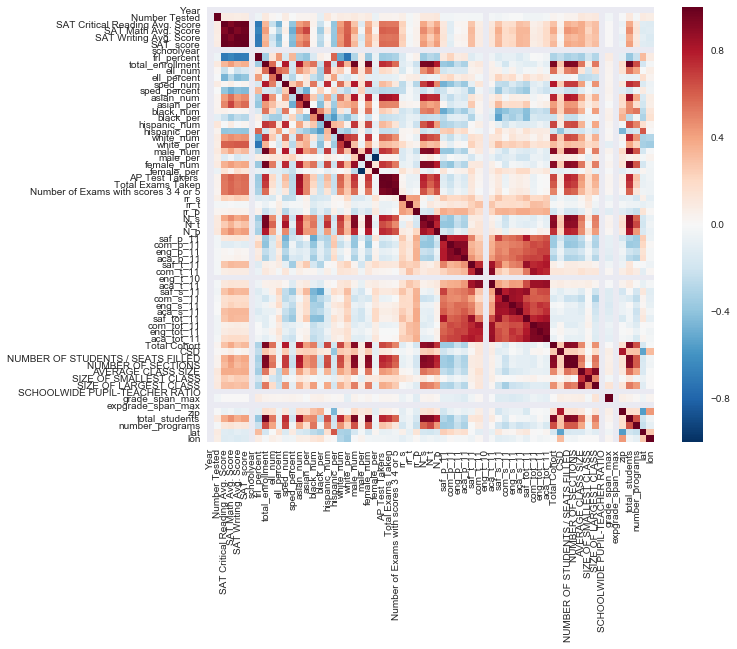

In [66]:
corr = base_data.corr(method="pearson")
sns.heatmap(corr)

**SAT_score:**

In [67]:
base_data.corr()['SAT_score']

Year                                             NaN
Number Tested                           8.127817e-02
SAT Critical Reading Avg. Score         9.868201e-01
SAT Math Avg. Score                     9.726430e-01
SAT Writing Avg. Score                  9.877708e-01
SAT_score                               1.000000e+00
schoolyear                                       NaN
frl_percent                            -7.018217e-01
total_enrollment                        3.668201e-01
ell_num                                -1.535745e-01
ell_percent                            -3.981643e-01
sped_num                                3.486852e-02
sped_percent                           -4.413665e-01
asian_num                               4.748801e-01
asian_per                               5.686267e-01
black_num                               2.788331e-02
black_per                              -2.827907e-01
hispanic_num                            2.568811e-02
hispanic_per                           -3.9263

**Correlation [coefficient](http://www.sjsu.edu/faculty/gerstman/StatPrimer/correlation.pdf):**

0 < |r| < 0.3 weak correlation

0.3 < |r| < 0.7 moderate correlation

|r| > 0.7 strong correlation

From 'SAT_score' correlation above, 

* 'SAT Math Avg. Score' and 'SAT Writing Avg. Score' strongly correlates with 'SAT_score'
* 'ell_percent' correlates negatively with 'SAT_score'
* 'total_enrollment' correlates positively with 'SAT_score'
    * smaller schools are not necessarily having better scores than big ones
* It's possibile to identify some racial inequality in the data, with 'hispanic_per' and 'black_per' correlating negatively with 'SAT_score'
* 'female_per' correlates positively with 'SAT_score'
* 'male_per' correlates negatively with 'SAT_score'

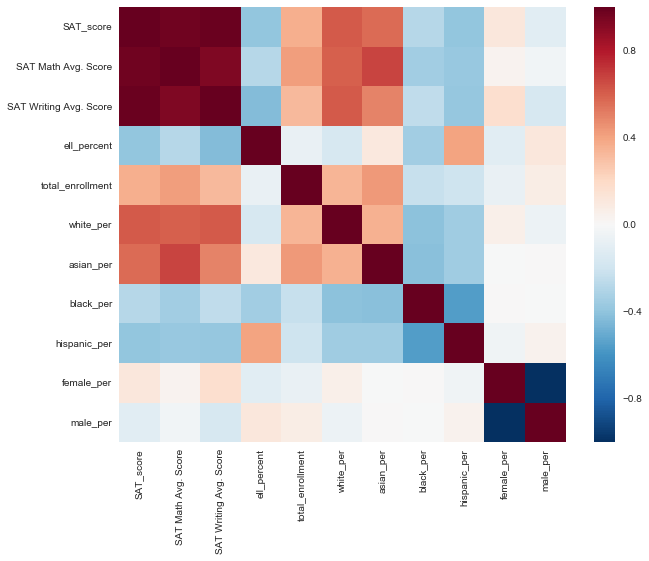

In [68]:
data2 = base_data[['SAT_score', 'SAT Math Avg. Score','SAT Writing Avg. Score',\
                   'ell_percent' ,'total_enrollment', 'white_per', 'asian_per', 'black_per',\
                   'hispanic_per', 'female_per', 'male_per']].copy()
corr2 = data2.corr()
sns.heatmap(corr2)

In [69]:
corr2

,SAT_score,SAT Math Avg. Score,SAT Writing Avg. Score,ell_percent,total_enrollment,white_per,asian_per,black_per,hispanic_per,female_per,male_per
SAT_score,1.000000,0.972643,0.987771,-0.398164,0.366820,0.610086,0.568627,-0.282791,-0.392637,0.110193,-0.110148
SAT Math Avg. Score,0.972643,1.000000,0.931385,-0.288870,0.420005,0.594215,0.677072,-0.350467,-0.375355,0.038328,-0.038282
SAT Writing Avg. Score,0.987771,0.931385,1.000000,-0.431007,0.324700,0.614186,0.499523,-0.253776,-0.385506,0.165860,-0.165814
ell_percent,-0.398164,-0.288870,-0.431007,1.000000,-0.077247,-0.169488,0.108101,-0.349728,0.401171,-0.110239,0.110257
total_enrollment,0.366820,0.420005,0.324700,-0.077247,1.000000,0.342339,0.435225,-0.233540,-0.204362,-0.074943,0.074971
white_per,0.610086,0.594215,0.614186,-0.169488,0.342339,1.000000,0.355057,-0.410711,-0.354608,0.060630,-0.060598
asian_per,0.568627,0.677072,0.499523,0.108101,0.435225,0.355057,1.000000,-0.415301,-0.358599,-0.000725,0.000759
black_per,-0.282791,-0.350467,-0.253776,-0.349728,-0.233540,-0.410711,-0.415301,1.000000,-0.561377,0.006746,-0.006744
hispanic_per,-0.392637,-0.375355,-0.385506,0.401171,-0.204362,-0.354608,-0.358599,-0.561377,1.000000,-0.044315,0.044274
female_per,0.110193,0.038328,0.165860,-0.110239,-0.074943,0.060630,-0.000725,0.006746,-0.044315,1.000000,-1.000000


In [70]:
data2.corr()['SAT_score']

SAT_score                 1.000000
SAT Math Avg. Score       0.972643
SAT Writing Avg. Score    0.987771
ell_percent              -0.398164
total_enrollment          0.366820
white_per                 0.610086
asian_per                 0.568627
black_per                -0.282791
hispanic_per             -0.392637
female_per                0.110193
male_per                 -0.110148
Name: SAT_score, dtype: float64

### Exploring the data

In [73]:
schools_map = folium.Map(location=[base_data['lat'].mean(), base_data['lon'].mean()], zoom_start=10)

for name, row in base_data.iterrows():
    # need to uncomment popupname, then run, then comment and run again - still dont know why
    #popupname = "{0}: {1}".format(row["DBN"], row["school_name"])
    
    folium.Marker([row["lat"], row["lon"]], popup = popupname).add_to(schools_map)  
marker_cluster = MarkerCluster().add_to(schools_map)
schools_map.save('schools.html')
schools_map

In [72]:
schools_heatmap = folium.Map(location=[base_data['lat'].mean(), base_data['lon'].mean()], zoom_start=10)
schools_heatmap.add_child(HeatMap([[row["lat"], row["lon"]] for name, row in base_data.iterrows()]))
schools_heatmap.save("heatmap.html")
schools_heatmap